In [1]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from IPython.display import clear_output
from tqdm import trange
from scipy.sparse import csr_matrix
from keras.optimizers import Adam, RMSprop

layers = tf.keras.layers

TensorFlow 2.x selected.


Using TensorFlow backend.


In [2]:
dataFrame = pd.read_csv('digits.csv')
dataFrame.describe()

,evtId,ipad,itime,amp
count,196230.000000,196230.000000,196230.000000,196230.000000
mean,5000.826041,43.302176,270.375152,293.583113
std,2886.154585,1.144196,1.448870,1107.341668
min,0.000000,40.000000,267.000000,1.000000
25%,2503.000000,42.000000,269.000000,20.130000
50%,4999.000000,43.000000,270.000000,108.800000
75%,7499.000000,44.000000,272.000000,333.075000
max,9998.000000,46.000000,274.000000,40950.000000


In [3]:
dataFrame['ipad'] -= 40
dataFrame['itime'] -= 267
dataFrame.describe()

,evtId,ipad,itime,amp
count,196230.000000,196230.000000,196230.000000,196230.000000
mean,5000.826041,3.302176,3.375152,293.583113
std,2886.154585,1.144196,1.448870,1107.341668
min,0.000000,0.000000,0.000000,1.000000
25%,2503.000000,2.000000,2.000000,20.130000
50%,4999.000000,3.000000,3.000000,108.800000
75%,7499.000000,4.000000,5.000000,333.075000
max,9998.000000,6.000000,7.000000,40950.000000


In [0]:
data = np.array(dataFrame)
data = np.array([data[data[:,0]==k] for k in np.unique(data[:,0])])

In [5]:
imgs = []

for i in range(0, data.shape[0]):
  row = np.array(data[i][:,1])
  col = np.array(data[i][:,2])
  amp = np.array(data[i][:,3])
  imgs.append(csr_matrix((amp, (row, col)), shape=(8, 8)).toarray())

imgs = np.array(imgs)
print(imgs.shape)

(9999, 8, 8)


In [6]:
print(np.expand_dims(imgs, axis=3).shape)

(9999, 8, 8, 1)


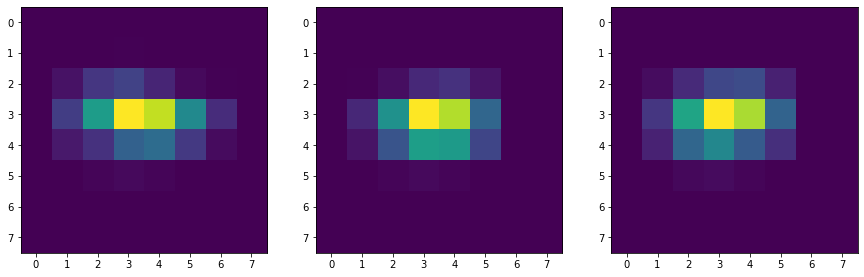

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(imgs[0]);
plt.subplot(1, 3, 2)
plt.imshow(imgs[1000]);
plt.subplot(1, 3, 3)
plt.imshow(imgs[5501]);

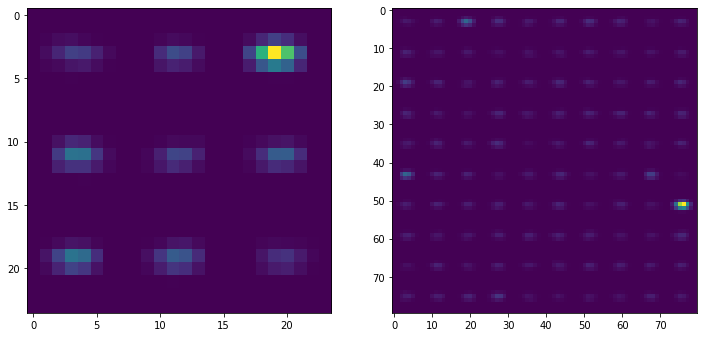

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imgs[:9].reshape(3, 3, 8, 8).transpose(0, 2, 1, 3).reshape(3 * 8, 3 * 8));
plt.subplot(1, 2, 2)
plt.imshow(imgs[:100].reshape(10, 10, 8, 8).transpose(0, 2, 1, 3).reshape(10 * 8, 10 * 8));

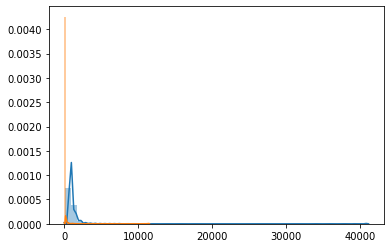

In [9]:
max_amps, mean_amps = [], []

for img in imgs:
  max_amps.append(np.amax(img))
  mean_amps.append(np.mean(img))

import seaborn as sns
sns.distplot(max_amps);
sns.distplot(mean_amps);

In [0]:
# Param
# LATENT_DIM = 32

# basic_generator = tf.keras.Sequential([
#   layers.Dense(128, input_shape=(LATENT_DIM,), activation='relu'),
#   layers.Dropout(0.1),
#   layers.Dense(64, activation='relu'),
#   layers.Dense(8 * 8, activation='relu'),
#   layers.Reshape((8, 8)),
# ])

# basic_discriminator = tf.keras.Sequential([
#   layers.Reshape((8 * 8,), input_shape=(8, 8, 1)),
#   layers.Dense(64, activation='relu'),
#   layers.Dropout(0.2),
#   layers.Dense(32, activation='relu'),
#   layers.Dropout(0.2),
#   layers.Dense(1),
# ])

# basic_generator.summary()
# basic_discriminator.summary()

In [11]:
# Param
LATENT_DIM = 32

discriminator = tf.keras.Sequential([                                   
  layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(8, 8, 1)),
  layers.LeakyReLU(),
  layers.Dropout(0.1),

  layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
  layers.LeakyReLU(),
  layers.Dropout(0.1),

  layers.Flatten(),
  layers.Dense(1),
])

generator = tf.keras.Sequential([
  layers.Dense(8 * 8 * 32, use_bias=False, input_shape=(LATENT_DIM,)),
  layers.BatchNormalization(),
  layers.LeakyReLU(),

  layers.Reshape((4, 4, 128)),

  layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(),

  layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False),
  layers.BatchNormalization(),
  layers.LeakyReLU(),

  layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Reshape((8, 8)),
])

generator.summary()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              65536     
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 32)          36864     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 32)          128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 32)         

In [0]:
X_train = imgs

# opt_d = tf.optimizers.RMSprop(1e-4)
# opt_g = tf.optimizers.RMSprop(1e-4)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)
generator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [0]:
@tf.function
def wasserstein_loss(y_true, y_pred):
    return tf.keras.mean(y_true * y_pred)

In [0]:
@tf.function
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))

@tf.function
def apply_discriminator(batch):
  return discriminator(tf.reshape(tf.cast(batch, 'float32'), (len(batch), 8, 8, 1)))

@tf.function
def discriminator_step(batch):
  fake_lables = tf.ones(shape=(len(batch), 1))
  real_lables = tf.zeros(shape=(len(batch), 1))
  
  with tf.GradientTape() as t:
    fake_data = gen_images(len(batch))
    fake_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(fake_lables, apply_discriminator(fake_data))
    )

    real_data = batch
    real_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(real_lables, apply_discriminator(real_data))
    )

    discriminator_loss = 0.5 * fake_loss + 0.5 * real_loss
  
  gradient = t.gradient(discriminator_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradient, discriminator.trainable_variables))

  return discriminator_loss


@tf.function
def generator_step(batch):
  fake_lables = tf.zeros(shape=(len(batch), 1))

  with tf.GradientTape() as t:
    fake_data = gen_images(len(batch))
    generator_loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(fake_lables, apply_discriminator(fake_data))
    )
  
  gradient = t.gradient(generator_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradient, generator.trainable_variables))
  return generator_loss

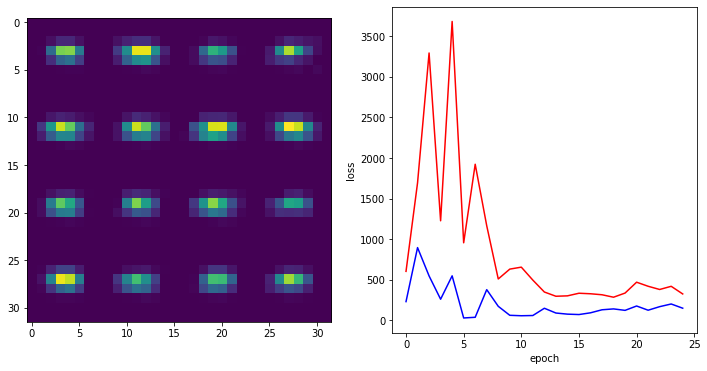

Done with epoch # 24


In [15]:
BATCH_SIZE = 64
N_EPOCHS = 25
NUM_DISC_STEPS = 2

discriminator_losses, generator_losses = [], []
for i_ep in range(N_EPOCHS):
  generator_epoch_loss, discriminator_epoch_loss = 0, 0
  np.random.shuffle(X_train)

  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[i_img:i_img + BATCH_SIZE]

    for i in range(0, NUM_DISC_STEPS):
      loss = discriminator_step(batch)
      discriminator_epoch_loss += loss.numpy()

    loss = generator_step(batch)
    generator_epoch_loss += loss.numpy()

  generator_losses.append(generator_epoch_loss)
  discriminator_losses.append(discriminator_epoch_loss)

  # PARAMS
  discriminator_optimizer.learning_rate.assign(discriminator_optimizer.learning_rate * 0.96)
  generator_optimizer.learning_rate.assign(generator_optimizer.learning_rate * 0.96)

  images = (gen_images(16).numpy())

  clear_output(wait=True)
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.imshow(images.reshape((4, 4, 8, 8)).transpose(0, 2, 1, 3).reshape(4 * 8, 4 * 8))
  plt.subplot(1, 2, 2)
  plt.plot(generator_losses, color='red')
  plt.plot(discriminator_losses, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  print("Done with epoch #", i_ep)

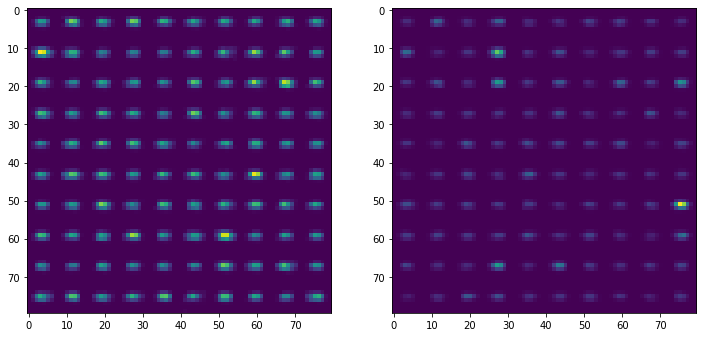

In [17]:
generated_imgs = gen_images(100)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.array(generated_imgs).reshape(10, 10, 8, 8).transpose(0, 2, 1, 3).reshape(10 * 8, 10 * 8));
plt.subplot(1, 2, 2)
plt.imshow(imgs[:100].reshape(10, 10, 8, 8).transpose(0, 2, 1, 3).reshape(10 * 8, 10 * 8));

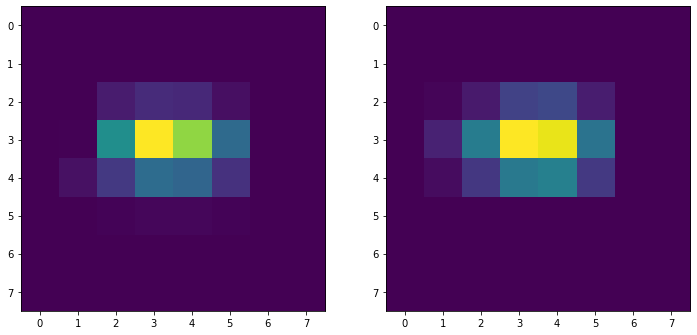

In [25]:
generated_imgs = gen_images(1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.array(generated_imgs).reshape(1, 1, 8, 8).transpose(0, 2, 1, 3).reshape(1 * 8, 1 * 8));
plt.subplot(1, 2, 2)
plt.imshow(imgs[:1].reshape(1, 1, 8, 8).transpose(0, 2, 1, 3).reshape(1 * 8, 1 * 8));